## Assignment 2 (Fundmanetals of DS)
### Link prediction for removed edges in a social network dataset
BUG/Fix Fairness with attributes experiments

BUG/Fix: github for complete metrics

In [103]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import pandas as pd
import math
from collections import defaultdict


## Read edgelist and build graph

In [104]:
# Load graph from edgelist efficiently (no drawing)
path = 'datasets/edges_train.edgelist'

# Prefer fast chunked load via pandas; fallback to networkx.read_edgelist
G = nx.Graph()
try:
    # read two columns (source,target); file appears comma-separated
    cols = ['u', 'v']
    iter_csv = pd.read_csv(
        path,
        header=None,
        names=cols,
        usecols=[0, 1],
        dtype={'u': 'int64', 'v': 'int64'},
        chunksize=1_000_000,
        engine='c'
    )
    for chunk in iter_csv:
        G.add_edges_from(chunk.itertuples(index=False, name=None))
    print('Loaded with pandas chunks')
except Exception as e:
    print('Pandas chunked load failed:', e)
    G = nx.read_edgelist(path, delimiter=',', data=False, nodetype=int)
    print('Loaded with nx.read_edgelist')

# Basic counts
N = G.number_of_nodes()
E = G.number_of_edges()
print('The network has', N, 'nodes')
print('The network has', E, 'edges')

Loaded with pandas chunks
The network has 1500 nodes
The network has 6600 edges


## Description/ summary statistics

In [105]:
# quick single-line summary (use nx.info if available, otherwise fallback)
# using much exception handling to avoid crashes
try:
    info = nx.info(G)
except Exception:
    try:
        dens = nx.density(G)
    except ZeroDivisionError:
        dens = float('nan')
    info = f"nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}, density: {dens:.4f}"
print(info)

# richer overview
n = G.number_of_nodes()

if n > 0:
    try:
        print("avg clustering:", nx.average_clustering(G))
    except Exception as e:
        print("avg clustering: error -", e)
else:
    print("avg clustering: N/A (empty graph)")

try:
    print("degree assortativity:", nx.degree_assortativity_coefficient(G))
except ZeroDivisionError:
    print("degree assortativity: N/A (division by zero)")
except Exception as e:
    print("degree assortativity: error -", e)

try:
    print("number connected components:", nx.number_connected_components(G))
except Exception as e:
    print("number connected components: error -", e)

# degree distribution and basic stats
deg = np.array([d for _, d in G.degree()]) if n > 0 else np.array([])
if deg.size > 0:
    print("degree: min/median/mean/max =", deg.min(), np.median(deg), deg.mean(), deg.max())
    print("degree histogram (counts by degree):", nx.degree_histogram(G))
else:
    print("degree: N/A (no nodes)")

# shortest-path stats (only if connected and has >=2 nodes)
if n >= 2 and nx.is_connected(G):
    print("avg shortest path length:", nx.average_shortest_path_length(G))
else:
    print("avg shortest path length: N/A (graph not connected or too small)")

nodes: 1500, edges: 6600, density: 0.0059
avg clustering: 0.1276746126115435
degree assortativity: -0.12341048065233655
number connected components: 1
degree: min/median/mean/max = 2 6.0 8.8 71
degree histogram (counts by degree): [0, 0, 2, 40, 179, 375, 234, 158, 109, 72, 53, 37, 30, 21, 14, 21, 10, 19, 13, 8, 10, 6, 5, 8, 7, 5, 3, 5, 5, 1, 4, 1, 3, 1, 2, 0, 3, 1, 2, 2, 0, 3, 3, 1, 1, 3, 2, 2, 2, 1, 0, 1, 1, 1, 1, 2, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1]
avg shortest path length: 3.9326012897487215
avg shortest path length: 3.9326012897487215


### How many edges weighted?

In [106]:
# Check if edges have a 'weight' attribute
num_w = sum(1 for _,_,d in G.edges(data=True) if 'weight' in d)
print(f"weighted edges: {num_w}/{G.number_of_edges()}")  # likely 0/N

weighted edges: 0/6600


## Basic EDA

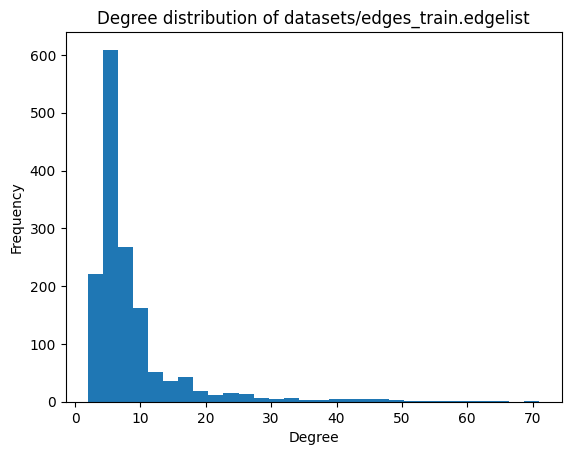

Number of Nodes: 1500
Number of Edges: 6600
Density: 0.005870580386924617
Average Clustering Coefficient: 0.1276746126115435
Number of Connected Components: 1
Average Degree: 8.8


In [107]:

# Basic EDA
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)
avg_clustering = nx.average_clustering(G)
connected_components = nx.number_connected_components(G)
degrees = [deg for _, deg in G.degree()]

# Summary metrics
eda_summary = {
    "Number of Nodes": num_nodes,
    "Number of Edges": num_edges,
    "Density": density,
    "Average Clustering Coefficient": avg_clustering,
    "Number of Connected Components": connected_components,
    "Average Degree": sum(degrees) / len(degrees),
}

# Display degree distribution
plt.hist(degrees, bins=30)
plt.title(f"Degree distribution of {path}")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

# Print summary
for key, value in eda_summary.items():
    print(f"{key}: {value}")

## Finding optimal Modularity as a result of resolution. Fixing resolution:
* Higher resolution ⇒ more, smaller communities. You start splitting real groups into subgroups, so 
e_cc gains don’t compensate the penalty term a^2_c, and Q drops.
* Falling Q suggests over-segmentation: communities become less “structural” and often less useful on their own.

In [108]:

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
import random
import community as community_louvain

def sample_negatives(G, num, rng):
    # sample non-edges uniformly; retry if edge exists
    nodes = list(G.nodes())
    neg = set()
    while len(neg) < num:
        u = rng.choice(nodes); v = rng.choice(nodes)
        if u == v: 
            continue
        if not G.has_edge(u, v):
            # undirected canonical order
            neg.add((u, v) if u <= v else (v, u))
    return list(neg)

def adamic_adar_pairs(G, pairs):
    # compute AA only for requested pairs
    idx = {(min(u,v), max(u,v)): i for i,(u,v) in enumerate(pairs)}
    aa = np.zeros(len(pairs), dtype=float)
    for u, v, score in nx.adamic_adar_index(G, pairs):
        aa[idx[(min(u,v), max(u,v))]] = score if score is not None else 0.0
    return aa

def eval_resolutions(G, resolutions=(0.5, 1.0, 2.0, 4.0, 8.0), k_folds=3, max_pos_eval=50_000, seed=42):
    rng = np.random.RandomState(seed)
    pos_edges = list(G.edges())
    rng.shuffle(pos_edges)
    if len(pos_edges) > max_pos_eval:
        pos_edges = pos_edges[:max_pos_eval]  # subsample for speed
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=seed)
    results = []

    for res in resolutions:
        fold_metrics = []
        for train_idx, test_idx in kf.split(pos_edges):
            # split positives
            pos_train = [pos_edges[i] for i in train_idx]
            pos_test = [pos_edges[i] for i in test_idx]

            # build training graph (remove held-out edges)
            G_train = G.copy()
            G_train.remove_edges_from(pos_test)

            # match negatives to test size, ensure they are non-edges in training graph
            neg_test = sample_negatives(G_train, len(pos_test), rng)

            # run Louvain on training graph (largest CC)
            if G_train.number_of_edges() == 0:
                # degenerate case
                partition = {}
            else:
                largest_cc = max(nx.connected_components(G_train), key=len)
                G_cc = G_train.subgraph(largest_cc)
                partition = community_louvain.best_partition(G_cc, weight='weight', resolution=res, random_state=seed)
            
            # features for test edges built from G_train only
            test_pairs = pos_test + neg_test
            y = np.array([1]*len(pos_test) + [0]*len(neg_test), dtype=int)

            # same-community indicator (nodes outside partition => 0)
            same_comm = []
            for u, v in test_pairs:
                cu = partition.get(u, None)
                cv = partition.get(v, None)
                same_comm.append(1 if (cu is not None and cu == cv) else 0)
            same_comm = np.array(same_comm, dtype=float)

            # Adamic-Adar from training graph
            aa = adamic_adar_pairs(G_train, test_pairs)

            X = np.vstack([same_comm, aa]).T

            # simple classifier
            clf = LogisticRegression(max_iter=1000, n_jobs=None)
            clf.fit(X, y)
            p = clf.predict_proba(X)[:, 1]

            auc = roc_auc_score(y, p)
            ap = average_precision_score(y, p)
            fold_metrics.append((auc, ap))

        auc_mean = float(np.mean([m[0] for m in fold_metrics]))
        ap_mean = float(np.mean([m[1] for m in fold_metrics]))
        results.append((res, auc_mean, ap_mean))
        print(f"resolution={res:<5} AUC={auc_mean:.4f} AP={ap_mean:.4f}")

    return results

# Run evaluation and detect diminishing returns (plateau if gain < 0.002 AUC)
results = eval_resolutions(G, resolutions=[0.25, 0.5, 1.0, 2.0, 4.0], k_folds=3, max_pos_eval=30_000, seed=42)
auc_by_res = [r[1] for r in results]
res_list = [r[0] for r in results]
deltas = [auc_by_res[i]-auc_by_res[i-1] for i in range(1,len(auc_by_res))]
plateau_idx = next((i for i,d in enumerate(deltas, start=1) if d < 0.002), len(res_list)-1)
chosen_res = res_list[plateau_idx]
print(f"Chosen resolution (plateau rule): {chosen_res} (ΔAUC<{0.002})")


resolution=0.25  AUC=0.7623 AP=0.7456
resolution=0.5   AUC=0.8865 AP=0.8488
resolution=0.5   AUC=0.8865 AP=0.8488
resolution=1.0   AUC=0.8860 AP=0.8515
resolution=1.0   AUC=0.8860 AP=0.8515
resolution=2.0   AUC=0.8653 AP=0.8317
resolution=2.0   AUC=0.8653 AP=0.8317
resolution=4.0   AUC=0.6850 AP=0.6809
Chosen resolution (plateau rule): 1.0 (ΔAUC<0.002)
resolution=4.0   AUC=0.6850 AP=0.6809
Chosen resolution (plateau rule): 1.0 (ΔAUC<0.002)


## ANalysis results picking resolution:

AP: Average Precision. the area under the precision–recall curve (with step-wise interpolation).
* Best for imbalanced data; the baseline AP ≈ positive class prevalence.
* Higher is better; unlike ROC AUC, AP focuses on positive-class ranking quality.

## Modularity Louvain + picked resolution, to obtain Communities

🧩 Number of clusters detected: 6
📊 Modularity score (standard, ignores resolution): 0.769

Top 10 largest clusters by size:
0    251
4    250
3    250
1    250
5    250
2    249
Name: count, dtype: int64


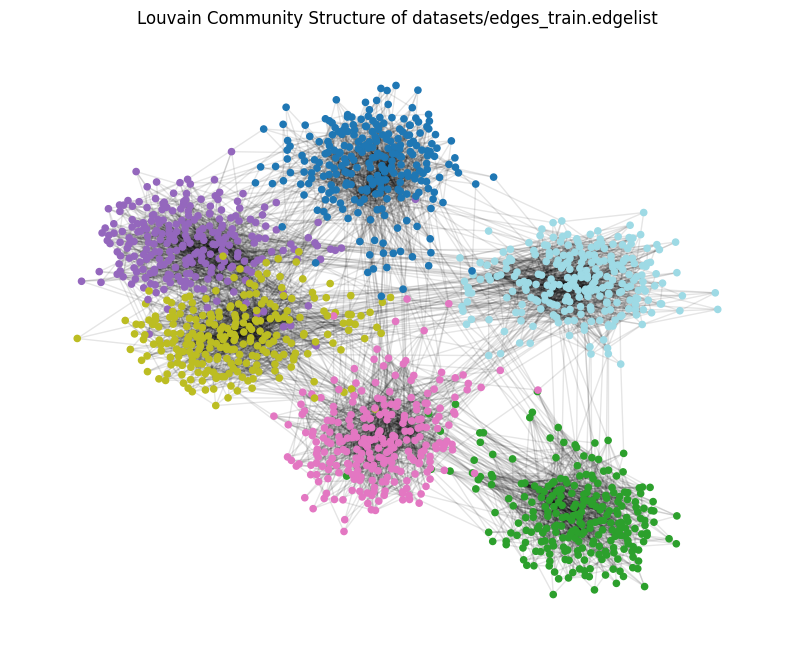

In [109]:
# --- 1️⃣ Detecting Communities (Clusters) with Louvain Modularity ---

import networkx as nx
import community as community_louvain  # python-louvain package
import matplotlib.pyplot as plt
import pandas as pd

# Use largest connected component for meaningful community detection
largest_cc = max(nx.connected_components(G), key=len)
G_cc = G.subgraph(largest_cc).copy()

# Set resolution (lower -> larger communities, higher -> smaller/more communities)
resolution = 1  # try values like 0.5, 1.0, 1.5, 2.0

# Compute Louvain communities with controlled resolution and fixed seed
partition = community_louvain.best_partition(
    G_cc, weight='weight', resolution=resolution, random_state=42
)

# Add community labels to graph nodes
nx.set_node_attributes(G_cc, partition, 'community')

# Compute modularity (standard; no resolution kwarg in your version)
modularity_std = community_louvain.modularity(partition, G_cc, weight='weight')

# Count communities and sizes
num_clusters = len(set(partition.values()))
cluster_sizes = pd.Series(list(partition.values())).value_counts().sort_values(ascending=False)

print(f"🧩 Number of clusters detected: {num_clusters}")
print(f"📊 Modularity score (standard, ignores resolution): {modularity_std:.3f}")
print("\nTop 10 largest clusters by size:")
print(cluster_sizes.head(10))

# --- Optional visualization of a subset ---
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_cc, seed=42)
communities = [partition[node] for node in G_cc.nodes()]
nx.draw_networkx_nodes(G_cc, pos, node_size=20, node_color=communities, cmap='tab20')
nx.draw_networkx_edges(G_cc, pos, alpha=0.1)
plt.title(f"Louvain Community Structure of {path}")
plt.axis("off")
plt.show()

## Link prediction prep

## BUG/FIX: use built in for NetworkX, now self made

Common neighbors, AA and JC all capture "completing the triangle" - to be used together?

In [110]:
# Precompute clustering coefficients once for all nodes
clustering = nx.clustering(G)  # dict: node -> coefficient in [0,1]

# Preferential attachment
pa = np.zeros((N, N))
preds = nx.preferential_attachment(G, [(i, j) for i in range(N) for j in range(N)])
for u, v, p in preds:
    pa[u, v] = p

# Link-prediction metrics
from networkx.algorithms.link_prediction import (
    jaccard_coefficient,
    adamic_adar_index,
    resource_allocation_index,
)

def _first_score(gen, default=0.0):
    for _, _, s in gen:
        return float(s)
    return float(default)

# Feature generator for each node pair
def getFeature(G, i, j):
    # Core similarities
    cn  = sum(1 for _ in nx.common_neighbors(G, i, j))
    jac = _first_score(jaccard_coefficient(G, [(i, j)]))
    aa  = _first_score(adamic_adar_index(G, [(i, j)]))
    ra  = _first_score(resource_allocation_index(G, [(i, j)]))

    # Degrees and Preferential Attachment
    di, dj = G.degree(i), G.degree(j)
    pa_ij = pa[i, j] if i < pa.shape[0] and j < pa.shape[1] else di * dj

    # Clustering coefficients
    ci, cj = clustering.get(i, 0.0), clustering.get(j, 0.0)
    cc_mean = (ci + cj) / 2
    cc_diff = abs(ci - cj)

    return [pa_ij, cn, jac, aa, ra, di, dj, cc_mean, cc_diff]

# Updated feature names (must match the order above)
feature_names = [
    "PA",
    "CN",
    "Jaccard",
    "AdamicAdar",
    "ResAlloc",
    "deg_i",
    "deg_j",
    "CC_mean",
    "CC_diff"
]


## Create negative set. Split for training. Train and Test

In [111]:
NEG_POS_RATIO = 2  # try 1, 2, 5
rng = np.random.default_rng(42)

X, Y = [], []

# Positives: existing edges in H
positives = list(G.edges())
n_pos = len(positives)

# Candidate non-edges in H
nodes = list(G.nodes())
non_edges_all = [(u, v) for i, u in enumerate(nodes) for v in nodes[i+1:] if not G.has_edge(u, v)]

# Sample negatives according to the ratio
n_neg = min(NEG_POS_RATIO * n_pos, len(non_edges_all))
negatives = list(rng.choice(non_edges_all, size=n_neg, replace=False))

# Build dataset
for (i, j) in positives:
    X.append(getFeature(G, i, j))
    Y.append(1)

for (i, j) in negatives:
    X.append(getFeature(G, i, j))
    Y.append(0)

## Bug/Fix: Basic EDA for the groups (attribute) - like degree distribution

In [112]:
# Nodes per attribute (counts for nodes present in G)
import pandas as pd

if 'G' not in globals():
    raise RuntimeError('Graph G not found. Run the cells that construct G first.')

# Load attributes if not already loaded
if 'attrs' not in globals():
    attrs = pd.read_csv('datasets/attributes.csv', dtype={'ID': 'int64', 'attribute': 'category'})

nodes_in_graph = set(G.nodes())

counts_in_graph = (
    attrs.loc[attrs['ID'].isin(nodes_in_graph)]
         .groupby('attribute', observed=True)['ID']
         .count()
         .rename('nodes_in_graph')
         .sort_values(ascending=False)
         .to_frame()
)

display(counts_in_graph)

,nodes_in_graph
attribute,
d,250
f,250
l,250
m,250
x,250
y,250


Group size and degree summary by attribute:
            count   mean  median  min  max
attribute                                
d            250  8.724     6.0    3   62
f            250  8.776     6.0    2   53
l            250  9.008     6.0    3   58
m            250  8.784     6.0    3   63
x            250  9.016     6.0    3   71
y            250  8.492     6.0    2   60


C:\Users\mariu\AppData\Local\Temp\ipykernel_22920\1849087270.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = attrs.groupby('attribute')['degree'].agg(['count', 'mean', 'median', 'min', 'max']).sort_values('count', ascending=False)


<Figure size 900x500 with 0 Axes>

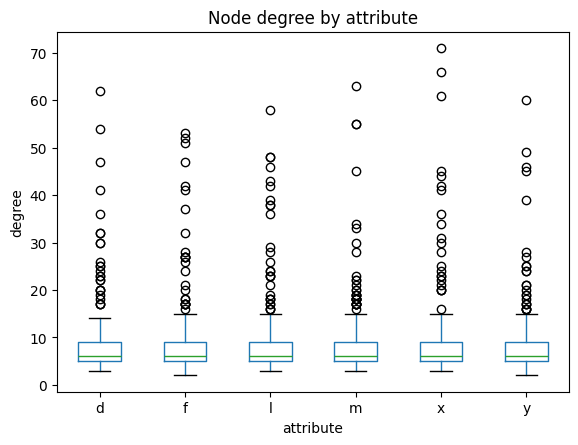

" for a in unique_attrs:\n    sub = attrs.loc[attrs['attribute'] == a, 'degree']\n    if sub.empty:\n        continue\n    plt.figure(figsize=(7, 4))\n    plt.hist(sub, bins=bins, color='tab:blue', alpha=0.8, edgecolor='black')\n    plt.title(f'Degree distribution — attribute = {a} (n={len(sub)})')\n    plt.xlabel('degree')\n    plt.ylabel('count')\n    plt.tight_layout()\n    plt.show() "

In [113]:
# EDA on attributes: degree distribution per node and per attribute group
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load attributes
attrs_path = 'datasets/attributes.csv'
attrs = pd.read_csv(attrs_path, dtype={'ID': 'int64', 'attribute': 'category'})

# 2) Map node degree from G onto the attributes table
if 'G' not in globals():
    raise RuntimeError("Graph G not found. Please run the earlier cells that construct G.")

deg_dict = dict(G.degree())
attrs['degree'] = attrs['ID'].map(deg_dict).fillna(0).astype(int)

# Quick summary by attribute
summary = attrs.groupby('attribute')['degree'].agg(['count', 'mean', 'median', 'min', 'max']).sort_values('count', ascending=False)
print("Group size and degree summary by attribute:\n", summary)

# 3) Boxplot of degree by attribute
plt.figure(figsize=(9, 5))
attrs.boxplot(column='degree', by='attribute', grid=False)
plt.title('Node degree by attribute')
plt.suptitle('')  # remove automatic suptitle from pandas
plt.xlabel('attribute')
plt.ylabel('degree')
plt.show()

# 4) Individual histograms per attribute
unique_attrs = list(attrs['attribute'].cat.categories) if hasattr(attrs['attribute'], 'cat') else sorted(attrs['attribute'].unique())

# Use consistent bins across groups for comparability
max_deg = int(attrs['degree'].max())
bins = min(40, max(10, max_deg + 1))  # cap to avoid too many empty bins

""" for a in unique_attrs:
    sub = attrs.loc[attrs['attribute'] == a, 'degree']
    if sub.empty:
        continue
    plt.figure(figsize=(7, 4))
    plt.hist(sub, bins=bins, color='tab:blue', alpha=0.8, edgecolor='black')
    plt.title(f'Degree distribution — attribute = {a} (n={len(sub)})')
    plt.xlabel('degree')
    plt.ylabel('count')
    plt.tight_layout()
    plt.show() """

#individual histograms are very similar. as boxplot shows.

### BUG/Fix: For EDA can do ANOVA, to say if we would be discriminating based on group by using the degree - connectivity. in a way have no choice. thats the baseline.

## Better prediciton for part 1, using attributes as prediction (NO demographic parity. Other fairness formulas come later)

In [114]:
# Attribute pair features with original labels: attr_pair_label1_label2 (+ unknown flag)

import numpy as np
import pandas as pd
import re

if 'X' not in globals() or 'Y' not in globals():
    raise RuntimeError("Build X and Y first.")
if 'positives' not in globals() or 'negatives' not in globals():
    raise RuntimeError("Need positives / negatives in scope.")

# Load attribute table
if 'attrs' in globals():
    attrs_df = attrs.copy()
else:
    attrs_df = pd.read_csv('datasets/attributes.csv', dtype={'ID':'int64','attribute':'category'})

# Sanitize labels to safe tokens for feature names
def sanitize(label: str) -> str:
    return re.sub(r'[^A-Za-z0-9]+', '', str(label)).lower() or 'blank'

# Build maps
attrs_df['attr_label'] = attrs_df['attribute'].astype(str)
attr_map = dict(zip(attrs_df['ID'].astype(int), attrs_df['attr_label']))

# Unique labels present for nodes in graph (only those that actually appear)
nodes_in_graph = set( n for edge in positives+negatives for n in edge )
used_labels = sorted({attr_map.get(int(n)) for n in nodes_in_graph if attr_map.get(int(n)) is not None})

# Unordered combos including same-label
combos = []
for i,a in enumerate(used_labels):
    for b in used_labels[i:]:
        combos.append( (a,b) )

# Feature names
pair_feature_names = [f"attr_pair_{sanitize(a)}_{sanitize(b)}" for (a,b) in combos]
unknown_col = "attr_pair_unknown_any"
all_new_cols = pair_feature_names + [unknown_col]

if any(c in feature_names for c in all_new_cols):
    print("Attribute pair (label) features already present. Skipping.")
else:
    pairs_all = list(positives) + list(negatives)
    if len(pairs_all) != len(X):
        raise RuntimeError("pairs_all not aligned with X.")

    from collections import Counter
    combo_to_idx = {c:i for i,c in enumerate(combos)}
    counts = Counter()
    unknown_cnt = 0
    zeros_template = [0]*len(combos)

    for k,(u,v) in enumerate(pairs_all):
        lu = attr_map.get(int(u))
        lv = attr_map.get(int(v))
        if lu is None or lv is None:
            new_vec = zeros_template[:] + [1]
            unknown_cnt += 1
        else:
            a,b = sorted((lu,lv))
            new_vec = zeros_template[:]
            new_vec[combo_to_idx[(a,b)]] = 1
            new_vec += [0]
            counts[(a,b)] += 1
        X[k].extend(new_vec)

    feature_names.extend(all_new_cols)

    top = counts.most_common(6)
    print(f"Added {len(combos)} attr-pair label one-hot cols + unknown flag ({len(all_new_cols)} new features).")
    print("Top combos:", {f"{sanitize(a)}_{sanitize(b)}": c for (a,b),c in top})
    print("Unknown pairs:", unknown_cnt)
    print("Total features now:", len(feature_names))

Added 21 attr-pair label one-hot cols + unknown flag (22 new features).
Top combos: {'l_l': 1237, 'x_x': 1175, 'm_m': 1135, 'f_f': 1094, 'd_d': 1078, 'y_y': 1061}
Unknown pairs: 0
Total features now: 31


## Feature engineering

In [115]:
import numpy as np
import pandas as pd


feat_select= feature_names

# Map names to indices
name_to_idx = {n: i for i, n in enumerate(feature_names)}

# Verify all selected features exist
missing = [f for f in feat_select if f not in name_to_idx]
if missing:
    raise ValueError(f"Unknown features: {missing}. Valid names: {feature_names}")

# Select only the desired columns
feat_idx = np.array([name_to_idx[f] for f in feat_select], dtype=int)

def select_features(X, idx):
    X_arr = np.asarray(X, dtype=float)
    return X_arr[:, idx]

# Apply to both train and test sets
X_sel = select_features(X, feat_idx)

print("Selected features:", feat_select)
print("X_sel shape:", X_sel.shape)



Selected features: ['PA', 'CN', 'Jaccard', 'AdamicAdar', 'ResAlloc', 'deg_i', 'deg_j', 'CC_mean', 'CC_diff', 'attr_pair_d_d', 'attr_pair_d_f', 'attr_pair_d_l', 'attr_pair_d_m', 'attr_pair_d_x', 'attr_pair_d_y', 'attr_pair_f_f', 'attr_pair_f_l', 'attr_pair_f_m', 'attr_pair_f_x', 'attr_pair_f_y', 'attr_pair_l_l', 'attr_pair_l_m', 'attr_pair_l_x', 'attr_pair_l_y', 'attr_pair_m_m', 'attr_pair_m_x', 'attr_pair_m_y', 'attr_pair_x_x', 'attr_pair_x_y', 'attr_pair_y_y', 'attr_pair_unknown_any']
X_sel shape: (19800, 31)


## Train and evaluate 5 models

In [116]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state = 42, stratify=Y)

### Bug/Fix: hyperparameter tuning + choice of classifier

### Code to halt unless you want to train yourself (takes 5-10 minutes for 5 models at 2x more negative than positive Y)

In [117]:
# Halt further execution of the notebook (graceful)
import sys
print("Halting execution here.")
raise SystemExit(0)

# Or, to shutdown the kernel entirely (stops all running code)
from IPython import get_ipython
ip = get_ipython()
if ip is not None:
    ip.kernel.do_shutdown(restart=False)

Halting execution here.


SystemExit: 0

C:\Users\mariu\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## train 5 models

In [118]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler 
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import numpy as np

X_arr, Y_arr = np.asarray(X_sel), np.asarray(Y)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "LR": make_pipeline(RobustScaler(), LogisticRegression(random_state=0, C=2, max_iter=2000, solver='lbfgs', class_weight='balanced')),
    #"SVC-RBF": make_pipeline(RobustScaler(), SVC(C=1.0, gamma='scale', probability=True, random_state=0)),
    #"GB": GradientBoostingClassifier(random_state=0),
    #"MLP": make_pipeline(RobustScaler(), MLPClassifier(hidden_layer_sizes=(16,), alpha=1e-2, max_iter=2000, random_state=0)),
}   

for name, clf in models.items():
    acc = cross_val_score(clf, X_arr, Y_arr, cv=cv, scoring='accuracy').mean()
    auc = cross_val_score(clf, X_arr, Y_arr, cv=cv, scoring='roc_auc').mean()
    print(f"{name}: Accuracy={acc:.2f} ROC AUC={auc:.3f}")

#5m with 9 input features and 2x more false than true in Y. results havent improved with 2 CCs. next add attributes.

LR: Accuracy=0.84 ROC AUC=0.910


# Start here for results analysis:

### For an unseen list of edges (CSV), show the prediction based on our model

In [119]:
# Return Solution (revised): build features for unseen pairs with full feature schema

import pandas as pd
import numpy as np
import re

if 'getFeature' not in globals():
    raise RuntimeError("getFeature() not defined.")
if 'feature_names' not in globals():
    raise RuntimeError("feature_names not in scope.")
if 'G' not in globals():
    raise RuntimeError("Graph G not loaded.")
if 'feat_select' not in globals() or 'X_sel' not in globals():
    raise RuntimeError("feat_select / X_sel not prepared (run feature engineering cell).")
if 'Y' not in globals():
    raise RuntimeError("Y not found.")
if 'models' not in globals() or not models:
    raise RuntimeError("models dict empty.")

# Read solution input (assume first 2 columns are node IDs; ignore index_col)
inpTest = pd.read_csv('datasets/solutionInput.csv', sep=',')
if inpTest.shape[1] < 2:
    raise RuntimeError("solutionInput.csv must contain at least two columns for node IDs.")
u_col, v_col = inpTest.columns[:2]
pairs = [tuple(map(int, row)) for row in inpTest[[u_col, v_col]].itertuples(index=False, name=None)]

# Ensure nodes exist in graph to avoid errors
for u, v in pairs:
    if u not in G: G.add_node(u)
    if v not in G: G.add_node(v)

# Detect attribute-pair features
attr_pair_prefix = "attr_pair_"
has_attr_pairs = any(n.startswith(attr_pair_prefix) for n in feature_names)

# Prepare attribute map if needed
if has_attr_pairs:
    if 'attr_map' not in globals():
        # Build attr_map from attributes.csv
        attrs_df_tmp = pd.read_csv('datasets/attributes.csv', dtype={'ID':'int64','attribute':'category'})
        attr_map = dict(zip(attrs_df_tmp['ID'].astype(int), attrs_df_tmp['attribute'].astype(str)))
    # sanitize
    if 'sanitize' not in globals():
        def sanitize(label: str) -> str:
            return re.sub(r'[^A-Za-z0-9]+', '', str(label)).lower() or 'blank'

    # Indices and structural info
    try:
        first_attr_idx = next(i for i, n in enumerate(feature_names) if n.startswith(attr_pair_prefix))
    except StopIteration:
        first_attr_idx = len(feature_names)
    base_feature_count = first_attr_idx

    unknown_flag_name = "attr_pair_unknown_any"
    unknown_idx = feature_names.index(unknown_flag_name) if unknown_flag_name in feature_names else None
    attr_name_to_idx = {
        n: i for i, n in enumerate(feature_names)
        if n.startswith(attr_pair_prefix) and n != unknown_flag_name
    }
else:
    base_feature_count = len(feature_names)
    unknown_idx = None

def build_full_vector(u, v):
    # Base features
    base_vals = getFeature(G, u, v)
    if not has_attr_pairs:
        if len(base_vals) != base_feature_count:
            raise RuntimeError("Base feature count mismatch.")
        return base_vals
    # Initialize full vector
    vec = [0.0] * len(feature_names)
    if len(base_vals) != base_feature_count:
        raise RuntimeError("Base feature count mismatch vs training.")
    vec[:base_feature_count] = base_vals
    # Attribute pair one-hot
    lu = attr_map.get(int(u))
    lv = attr_map.get(int(v))
    if lu is None or lv is None:
        if unknown_idx is not None:
            vec[unknown_idx] = 1.0
        return vec
    a, b = sorted((lu, lv))
    fname = f"{attr_pair_prefix}{sanitize(a)}_{sanitize(b)}"
    idx = attr_name_to_idx.get(fname, unknown_idx)
    if idx is not None:
        vec[idx] = 1.0
    return vec

# Build full matrix for unseen pairs
X_unseen_full = np.asarray([build_full_vector(u, v) for (u, v) in pairs], dtype=float)

# Apply same feature selection (feat_select)
name_to_idx_all = {n: i for i, n in enumerate(feature_names)}
sel_idx = np.array([name_to_idx_all[n] for n in feat_select], dtype=int)
X_unseen_sel = X_unseen_full[:, sel_idx]

print(f"Unseen pairs: {len(pairs)}")
print(f"Full feature dim: {X_unseen_full.shape[1]}  Selected dim: {X_unseen_sel.shape[1]}")

# Store for next cell
X_unseen_predict = X_unseen_sel
pairs_unseen = pairs

Unseen pairs: 1466
Full feature dim: 31  Selected dim: 31


### Save our results for later testing

In [120]:
# Save predictions for ALL models (aligned feature dimensions)

import numpy as np
import pandas as pd
from pathlib import Path

if 'X_unseen_predict' not in globals():
    raise RuntimeError("Run the Return Solution cell first to build X_unseen_predict.")
if 'X_sel' not in globals():
    raise RuntimeError("X_sel (training selected feature matrix) missing.")
if 'Y' not in globals():
    raise RuntimeError("Y missing.")
if 'models' not in globals() or not models:
    raise RuntimeError("models dict empty.")

train_matrix = np.asarray(X_sel, dtype=float)
Y_arr = np.asarray(Y, dtype=int)
X_unseen_arr = np.asarray(X_unseen_predict, dtype=float)

out_dir = Path("datasets")
out_dir.mkdir(exist_ok=True, parents=True)

for name, mdl in models.items():
    # Fit on full selected training data (consistent with feature selection)
    try:
        mdl.fit(train_matrix, Y_arr)
    except Exception:
        mdl.fit(np.asarray(train_matrix), Y_arr)

    # Predict
    if hasattr(mdl, "predict_proba"):
        scores = mdl.predict_proba(X_unseen_arr)[:, 1]
    elif hasattr(mdl, "decision_function"):
        df = mdl.decision_function(X_unseen_arr)
        scores = 1.0 / (1.0 + np.exp(-df))
    else:
        # Fallback: use predictions as scores
        scores = mdl.predict(X_unseen_arr).astype(float)

    preds = (scores >= 0.5).astype(int)

    df_out = pd.DataFrame({
        "u": [u for u, _ in pairs_unseen],
        "v": [v for _, v in pairs_unseen],
        "prediction": preds,
        "score": scores
    })
    out_path = out_dir / f"assignment2_predictions_{name}.csv"
    df_out.to_csv(out_path, index=True, index_label="ID")
    print(f"Saved predictions -> {out_path}")

print("Done for all models.")

Saved predictions -> datasets\assignment2_predictions_LR.csv
Done for all models.


## Demographic parity: not using the attribute (which we pretend is a protected status) in our predictions

## Select less features

In [121]:
feat_select= [
    "PA",
    "CN",
    "Jaccard",
    "AdamicAdar",
    "ResAlloc",
    "deg_i",
    "deg_j",
    "CC_mean",
    "CC_diff"
]

# Map names to indices
name_to_idx = {n: i for i, n in enumerate(feature_names)}

# Verify all selected features exist
missing = [f for f in feat_select if f not in name_to_idx]
if missing:
    raise ValueError(f"Unknown features: {missing}. Valid names: {feature_names}")

# Select only the desired columns
feat_idx = np.array([name_to_idx[f] for f in feat_select], dtype=int)

# Apply to both train and test sets
X_sel = select_features(X, feat_idx)

print("Selected features:", feat_select)
print("X_sel shape:", X_sel.shape)



Selected features: ['PA', 'CN', 'Jaccard', 'AdamicAdar', 'ResAlloc', 'deg_i', 'deg_j', 'CC_mean', 'CC_diff']
X_sel shape: (19800, 9)


## Train models without regard to attribute

In [122]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler 
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import numpy as np

X_arr, Y_arr = np.asarray(X_sel), np.asarray(Y)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "LR": make_pipeline(RobustScaler(), LogisticRegression(random_state=0, C=2, max_iter=2000, solver='lbfgs', class_weight='balanced')),
    #"SVC-RBF": make_pipeline(RobustScaler(), SVC(C=1.0, gamma='scale', probability=True, random_state=0)),
    #"GB": GradientBoostingClassifier(random_state=0),
    #"MLP": make_pipeline(RobustScaler(), MLPClassifier(hidden_layer_sizes=(16,), alpha=1e-2, max_iter=2000, random_state=0)),
}   

for name, clf in models.items():
    acc = cross_val_score(clf, X_arr, Y_arr, cv=cv, scoring='accuracy').mean()
    auc = cross_val_score(clf, X_arr, Y_arr, cv=cv, scoring='roc_auc').mean()
    print(f"{name}: Accuracy={acc:.2f} ROC AUC={auc:.3f}")

#5m with 9 input features and 2x more false than true in Y. results havent improved with 2 CCs. next add attributes.

LR: Accuracy=0.81 ROC AUC=0.859


## Analyze demographic parity results

BUG/Fix: only runs on LR, and does fitting again.

In [123]:
# --- Node-level confusion metrics (each edge contributes to both endpoints) ---

import pandas as pd
import numpy as np

# Requires: pairs_test_sel (or pairs_test), y_test_sel (or y_test_arr), y_pred_sel, attr_map
# Adjust names if you are in the other split cell:
edge_pairs = pairs_test_sel  # change to pairs_test if using the earlier split cell
y_true = y_test_sel          # or y_test_arr
y_pred = y_pred_sel

if len(edge_pairs) != len(y_true) or len(y_true) != len(y_pred):
    raise ValueError("Length mismatch among edge_pairs, y_true, y_pred.")

# Collect node-level counts
node_stats = {}  # node -> dict(TP,FP,TN,FN,total_edges)
def ensure(n):
    if n not in node_stats:
        node_stats[n] = {"TP":0,"FP":0,"TN":0,"FN":0,"total":0}

for (u,v), yt, yp in zip(edge_pairs, y_true, y_pred):
    ensure(u); ensure(v)
    if yt==1 and yp==1:
        node_stats[u]["TP"]+=1; node_stats[v]["TP"]+=1
    elif yt==1 and yp==0:
        node_stats[u]["FN"]+=1; node_stats[v]["FN"]+=1
    elif yt==0 and yp==1:
        node_stats[u]["FP"]+=1; node_stats[v]["FP"]+=1
    else:  # yt==0 and yp==0
        node_stats[u]["TN"]+=1; node_stats[v]["TN"]+=1
    node_stats[u]["total"]+=1
    node_stats[v]["total"]+=1

# Build DataFrame
rows = []
for n, d in node_stats.items():
    TP,FP,FN,TN = d["TP"],d["FP"],d["FN"],d["TN"]
    tpr = TP / (TP+FN) if (TP+FN)>0 else np.nan
    fpr = FP / (FP+TN) if (FP+TN)>0 else np.nan
    prec = TP / (TP+FP) if (TP+FP)>0 else np.nan
    acc = (TP+TN) / d["total"] if d["total"]>0 else np.nan
    label = attr_map.get(int(n), "unknown")
    rows.append((n,label,d["total"],TP,FP,FN,TN,tpr,fpr,prec,acc))

node_df = pd.DataFrame(rows, columns=[
    "node","attribute","edge_samples","TP","FP","FN","TN","TPR","FPR","Precision","Accuracy"
])

print("Node-level performance (first 10):")
display(node_df.head(10))

# Aggregate by attribute (per-node averages, not edge-weighted)
group_summary = (
    node_df
    .groupby("attribute")
    .agg({
        "node":"count",
        "edge_samples":"sum",
        "TPR":"mean",
        "FPR":"mean",
        "Precision":"mean",
        "Accuracy":"mean"
    })
    .rename(columns={"node":"nodes"})
    .sort_values("nodes", ascending=False)
)

print("Attribute group summary (node-level averages):")
display(group_summary)

# (Optional) Edge-weighted averages per attribute (weights by each node's edge_samples)
def wavg(series, weights):
    m = weights.sum()
    return (series*weights).sum()/m if m>0 else np.nan

weighted_summary = (
    node_df
    .groupby("attribute")
    .apply(lambda g: pd.Series({
        "nodes": len(g),
        "edge_samples": g["edge_samples"].sum(),
        "TPR_w": wavg(g["TPR"], g["edge_samples"]),
        "FPR_w": wavg(g["FPR"], g["edge_samples"]),
        "Precision_w": wavg(g["Precision"], g["edge_samples"]),
        "Accuracy_w": wavg(g["Accuracy"], g["edge_samples"])
    }))
    .sort_values("nodes", ascending=False)
)

print("Attribute group summary (edge-weighted averages):")
display(weighted_summary)

# Note:
# - Edge counts are doubled overall (each edge contributes to two nodes).
# - Use per-node averages (group_summary) for fairness of node experience.
# - Use edge-weighted (weighted_summary) if you want higher-degree nodes to influence more.


Node-level performance (first 10):


,node,attribute,edge_samples,TP,FP,FN,TN,TPR,FPR,Precision,Accuracy
0,1295,l,28,10,2,2,14,0.833333,0.125000,0.833333,0.857143
1,1250,l,44,28,5,3,8,0.903226,0.384615,0.848485,0.818182
2,904,f,23,4,2,1,16,0.800000,0.111111,0.666667,0.869565
3,1398,l,19,1,2,1,15,0.500000,0.117647,0.333333,0.842105
4,172,x,21,1,0,4,16,0.200000,0.000000,1.000000,0.809524
5,1233,m,23,1,1,3,18,0.250000,0.052632,0.500000,0.826087
6,920,f,18,3,2,3,10,0.500000,0.166667,0.600000,0.722222
7,1178,m,17,1,0,4,12,0.200000,0.000000,1.000000,0.764706
8,314,d,26,7,2,3,14,0.700000,0.125000,0.777778,0.807692
9,466,d,14,0,1,3,10,0.000000,0.090909,0.000000,0.714286


Attribute group summary (node-level averages):


,nodes,edge_samples,TPR,FPR,Precision,Accuracy
attribute,,,,,,
d,250,5283,0.530272,0.103388,0.731863,0.808892
f,250,5181,0.559765,0.111441,0.712267,0.806598
l,250,5378,0.564895,0.106499,0.717093,0.816577
m,250,5217,0.590734,0.092420,0.754587,0.825617
x,250,5387,0.536425,0.118091,0.715408,0.807976
y,250,5234,0.558475,0.101621,0.725959,0.819968


Attribute group summary (edge-weighted averages):


C:\Users\mariu\AppData\Local\Temp\ipykernel_22920\1929883649.py:79: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,nodes,edge_samples,TPR_w,FPR_w,Precision_w,Accuracy_w
attribute,,,,,,
d,250.0,5283.0,0.557702,0.136028,0.711759,0.806171
f,250.0,5181.0,0.587112,0.142769,0.695674,0.805829
l,250.0,5378.0,0.597921,0.136867,0.707331,0.816846
m,250.0,5217.0,0.618270,0.119425,0.746432,0.823845
x,250.0,5387.0,0.573030,0.167196,0.704473,0.804715
y,250.0,5234.0,0.587518,0.126083,0.703115,0.817348


## Explanation for using below:
### Use weighted_summary only if you want performance proportional to traffic (nodes with many incident test edges count more) and thus closer to edge-volume view.

Details:

group_summary (unweighted)
- Metric_g = (1 / |Ng|) * Σ_{i in group g} metric_i
- Each node contributes equally. Fairness-of-individual-experience.

weighted_summary
- Metric_g_weighted = Σ edge_samples_i * metric_i / Σ edge_samples_i
- Expands influence of high-degree nodes. Answers: “What does a random interaction endpoint (sampled proportional to its activity) experience?”

Does weighting “mirror how many edges were correct/wrong”?
Partially. TPR_w = Σ TP_i / Σ (TP_i + FN_i). Because TP_i, FN_i double-count positive edges (once per endpoint), the factor 2 cancels, so algebraically it matches edge-level TPR if you considered edges duplicated per endpoint. For cross-group edges each endpoint is credited to its own group, so an edge spanning two attributes contributes to both groups’ denominators. That is intentional for node-experience framing, but it means weighted_summary is not a pure edge-partition statistic.

When to choose:

- Fairness claim (“average member of group A vs B gets similar recall”): use unweighted.
- Operational performance (“most of the correctly predicted links come from group A”): use weighted.

Mini example: Suppose group X has 2 nodes: one with TPR=1 on 2 positives, one with TPR=0 on 20 positives. Unweighted TPR_X = (1 + 0)/2 = 0.5 (average node experience) Weighted TPR_X = (12 + 020)/(2+20) = 2/22 ≈ 0.09 (volume-weighted) Edge-level perspective cares about the 22 positives → 0.09; fairness-across-individuals says typical node sees 0.5.

In [124]:

fair_df = group_summary.copy()

# Rename for clarity
fair_df = fair_df.rename(columns={
    "TPR": "recall",
    "FPR": "false_pos_rate",
    "Precision": "precision",
    "Accuracy": "accuracy"
})

# Predicted positive rate per node (need node_df)
# P(node positive | samples) ~ (TP + FP) / total edges involving node, then averaged per group
if 'node_df' in globals():
    per_node_ppr = (
        node_df.assign(PPR = (node_df.TP + node_df.FP) / node_df.edge_samples.replace(0, np.nan))
               .groupby('attribute')['PPR'].mean()
    )
    fair_df['pred_pos_rate'] = per_node_ppr

# Compute disparities (max-min) across groups for core metrics
metrics_for_gap = ['recall','false_pos_rate','precision','accuracy','pred_pos_rate']
for m in metrics_for_gap:
    if m in fair_df.columns:
        col = fair_df[m].dropna()
        if len(col) > 1:
            fair_df[m + '_gap'] = col.max() - col.min()

print("Per-node fairness metrics (group averages) and gaps:")
display(fair_df)

# Optional: pick a reference group (largest by nodes) and compute relative differences
ref_attr = fair_df.sort_values('nodes', ascending=False).index[0]
rel = {}
for m in ['recall','false_pos_rate','pred_pos_rate']:
    if m in fair_df.columns and m in fair_df:
        ref_val = fair_df.loc[ref_attr, m]
        if pd.notna(ref_val) and ref_val != 0:
            rel[m + '_ratio_vs_' + str(ref_attr)] = fair_df[m] / ref_val
rel_df = pd.DataFrame(rel)
print(f"Relative ratios vs largest group ({ref_attr}):")
display(rel_df)

Per-node fairness metrics (group averages) and gaps:


,nodes,edge_samples,recall,false_pos_rate,precision,accuracy,pred_pos_rate,recall_gap,false_pos_rate_gap,precision_gap,accuracy_gap,pred_pos_rate_gap
attribute,,,,,,,,,,,,
d,250,5283,0.530272,0.103388,0.731863,0.808892,0.237058,0.060463,0.025671,0.04232,0.019019,0.019593
f,250,5181,0.559765,0.111441,0.712267,0.806598,0.256651,0.060463,0.025671,0.04232,0.019019,0.019593
l,250,5378,0.564895,0.106499,0.717093,0.816577,0.244412,0.060463,0.025671,0.04232,0.019019,0.019593
m,250,5217,0.590734,0.092420,0.754587,0.825617,0.250243,0.060463,0.025671,0.04232,0.019019,0.019593
x,250,5387,0.536425,0.118091,0.715408,0.807976,0.241075,0.060463,0.025671,0.04232,0.019019,0.019593
y,250,5234,0.558475,0.101621,0.725959,0.819968,0.245313,0.060463,0.025671,0.04232,0.019019,0.019593


Relative ratios vs largest group (d):


,recall_ratio_vs_d,false_pos_rate_ratio_vs_d,pred_pos_rate_ratio_vs_d
attribute,,,
d,1.000000,1.000000,1.000000
f,1.055619,1.077896,1.082650
l,1.065294,1.030093,1.031023
m,1.114022,0.893912,1.055619
x,1.011604,1.142212,1.016946
y,1.053186,0.982916,1.034824


### Edge-level ( edges between SAME-attribute only) performance per attribute (no duplication)
### SAME

In [125]:
# Edge-level (same-attribute only) performance per attribute (no duplication)
import pandas as pd
import numpy as np

# edge_pairs, y_true, y_pred, attr_map must exist
rows = []
for (u,v), yt, yp in zip(edge_pairs, y_true, y_pred):
    au, av = attr_map.get(int(u)), attr_map.get(int(v))
    if au is None or av is None: 
        continue
    if au == av:  # restrict to intra-group edges
        rows.append((au, yt, yp))

edge_df = pd.DataFrame(rows, columns=["attr","y_true","y_pred"])
edge_summary = []
for attr, g in edge_df.groupby("attr"):
    tp = ((g.y_true==1)&(g.y_pred==1)).sum()
    fp = ((g.y_true==0)&(g.y_pred==1)).sum()
    fn = ((g.y_true==1)&(g.y_pred==0)).sum()
    tn = ((g.y_true==0)&(g.y_pred==0)).sum()
    tpr = tp / (tp+fn) if (tp+fn)>0 else np.nan
    fpr = fp / (fp+tn) if (fp+tn)>0 else np.nan
    edge_summary.append((attr, len(g), tp, fp, fn, tn, tpr, fpr))
edge_level_intra = pd.DataFrame(edge_summary, columns=["attr","edges","TP","FP","FN","TN","TPR","FPR"])
display(edge_level_intra.sort_values("edges", ascending=False))

,attr,edges,TP,FP,FN,TN,TPR,FPR
2,l,984,446,85,214,239,0.675758,0.262346
4,x,935,441,94,210,190,0.677419,0.330986
3,m,912,458,62,210,182,0.685629,0.254098
0,d,890,388,70,220,212,0.638158,0.248227
5,y,880,390,75,186,229,0.677083,0.246711
1,f,875,397,81,212,185,0.651888,0.304511


## Compare Demographic parity with using attributes in prediction (as before)

In [126]:
## compare two runs

## BUg/Fix: only on LR, and Trains again

## Which is our metric formula. do analysis how those groups impacted by:
- selection of no features that include attribute
- changing ...

## Bug/Fix for Fairness: Whether the better connected are better served. so other fairness than attributes but again business tradeoff, do you want to serve all equally mediocrily, or the better. 
Side: different classification based on group ? or arent these models doing that automatically ? DT would. different algo even for group? diff features? does it do automatically?

## Bug/Fix for Fairness: How feature choice affects prediction quality for each attribute group

## Fairlearn Fairness Evaluation: Full vs Restricted Feature Sets

This section compares model performance and fairness across two feature configurations:

1. Full feature set (all engineered features present in `feature_names`).
2. Restricted feature set (the reduced `feat_select` with only structural features, i.e. no attribute-based one-hot pairs).

Sensitive feature (for fairness): edge-level group label derived from endpoint attributes:
- `same:<label>`  – both endpoints share the same attribute label
- `cross`         – endpoints have different labels (both known)
- `unknown`       – at least one endpoint lacks an attribute

We compute Fairlearn metrics:
- Selection rate (predicted positive rate)
- True Positive Rate (TPR)
- False Positive Rate (FPR)
- Demographic Parity Difference / Ratio
- Equalized Odds Difference / Ratio

Interpretation:
- Use unweighted (per-edge) group metrics to assess whether the model behaves differently across edge groups.
- Differences close to 0 (and ratios close to 1) indicate more parity.

Note: If you executed the earlier "Halting" cell which raises `SystemExit`, re-run the notebook from the top **skipping** that cell before running this section.

c:\Users\mariu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Fairlearn MetricFrame: FULL feature set (threshold metrics) ===
                     accuracy       tpr       fpr  selection_rate
sensitive_feature_0                                              
cross                0.886439  0.451724  0.037639        0.099205
same:d               0.735795  0.983122  0.773913        0.914773
same:f               0.762048  0.983051  0.781250        0.924699
same:l               0.752044  0.983806  0.725000        0.899183
same:m               0.802395  0.995968  0.755814        0.934132
same:x               0.729970  0.991379  0.847619        0.946588
same:y               0.694006  0.985000  0.803419        0.917981
Overall:
accuracy          0.838384
tpr               0.830303
fpr               0.157576
selection_rate    0.381818
dtype: float64

=== Fairlearn MetricFrame: RESTRICTED feature set (threshold metrics) ===
                     accuracy       tpr       fpr  selection_rate
sensitive_feature_0                                              

,model,selection_rate_gap,tpr_gap,fpr_gap,selection_rate_ratio,tpr_ratio,fpr_ratio,accuracy_overall,roc_auc_overall
0,FULL,0.847382,0.544244,0.809980,0.104803,0.453553,0.044406,0.838384,0.901306
1,RESTRICTED,0.433474,0.122241,0.301759,0.262218,0.826608,0.207882,0.806061,0.852486


Lowest selection_rate gap: RESTRICTED
Lowest TPR gap: RESTRICTED
Lowest FPR gap: RESTRICTED


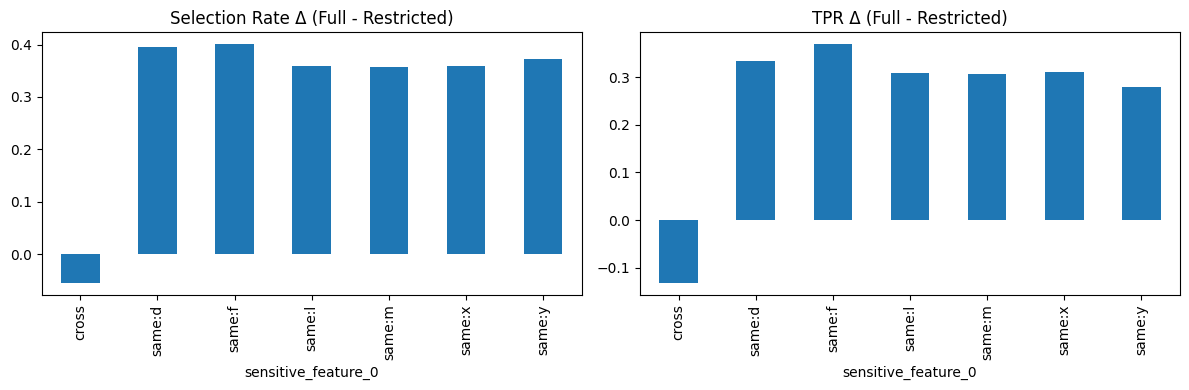


Interpretation Guidance:
- Gaps closer to 0 and ratios closer to 1 => better parity.
- Compare accuracy_overall & roc_auc_overall for utility trade-offs.
- selection_rate disparity ~ demographic parity; tpr & fpr disparities ~ equalized odds components.


In [129]:
# Fairlearn assessment between full and restricted feature sets (UPDATED: remove y_score unsupported in MetricFrame)
# Adjusted to compute ROC AUC per group manually outside MetricFrame.

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

try:
    import fairlearn.metrics as flm  # noqa: F401
except ImportError:
    raise ImportError("fairlearn not installed. Run: pip install fairlearn")

# ----------------------------- Helper: Build edge sensitive group labels -----------------------------
if 'positives' not in globals() or 'negatives' not in globals():
    raise RuntimeError("Need positives and negatives lists in scope to derive edge-level sensitive features.")

pairs_all = list(positives) + list(negatives)
if len(pairs_all) != len(X):
    raise RuntimeError("pairs_all length mismatch with X; ensure same order as when features were built.")

if 'attr_map' not in globals():
    attrs_df_tmp = pd.read_csv('datasets/attributes.csv', dtype={'ID':'int64','attribute':'category'})
    attr_map = dict(zip(attrs_df_tmp['ID'].astype(int), attrs_df_tmp['attribute'].astype(str)))

def edge_group_label(u, v):
    au = attr_map.get(int(u))
    av = attr_map.get(int(v))
    if (au is None) or (av is None):
        return 'unknown'
    if au == av:
        return f'same:{au}'
    return 'cross'

sensitive_full = np.array([edge_group_label(u, v) for (u, v) in pairs_all])

# ----------------------------- Train/Test split (edge-level) -----------------------------
X_arr_full = np.asarray(X, dtype=float)
Y_arr = np.asarray(Y, dtype=int)

X_train_full, X_test_full, y_train_full, y_test_full, s_train, s_test = train_test_split(
    X_arr_full, Y_arr, sensitive_full, test_size=0.3, random_state=42, stratify=Y_arr
)

# ----------------------------- Restricted feature matrix -----------------------------
restricted_feats = [
    'PA','CN','Jaccard','AdamicAdar','ResAlloc','deg_i','deg_j','CC_mean','CC_diff'
]
name_to_idx_all = {n:i for i,n in enumerate(feature_names)}
missing_restricted = [f for f in restricted_feats if f not in name_to_idx_all]
if missing_restricted:
    raise ValueError(f"Restricted features missing from feature_names: {missing_restricted}")
restricted_idx = np.array([name_to_idx_all[f] for f in restricted_feats], dtype=int)

X_train_restricted = X_train_full[:, restricted_idx]
X_test_restricted  = X_test_full[:, restricted_idx]

# ----------------------------- Base estimators -----------------------------
base_clf_full = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs', random_state=0)
base_clf_restricted = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs', random_state=0)

base_clf_full.fit(X_train_full, y_train_full)
base_clf_restricted.fit(X_train_restricted, y_train_full)

proba_full = base_clf_full.predict_proba(X_test_full)[:,1]
proba_restricted = base_clf_restricted.predict_proba(X_test_restricted)[:,1]

pred_full = (proba_full >= 0.5).astype(int)
pred_restricted = (proba_restricted >= 0.5).astype(int)

# ----------------------------- Fairlearn MetricFrame (without y_score) -----------------------------
from fairlearn.metrics import MetricFrame, true_positive_rate, false_positive_rate, selection_rate

metrics_dict = {
    'accuracy': accuracy_score,
    'tpr': true_positive_rate,
    'fpr': false_positive_rate,
    'selection_rate': selection_rate,
}

mf_full = MetricFrame(metrics=metrics_dict, y_true=y_test_full, y_pred=pred_full, sensitive_features=s_test)
mf_restricted = MetricFrame(metrics=metrics_dict, y_true=y_test_full, y_pred=pred_restricted, sensitive_features=s_test)

print("=== Fairlearn MetricFrame: FULL feature set (threshold metrics) ===")
print(mf_full.by_group)
print("Overall:")
print(mf_full.overall)
print()

print("=== Fairlearn MetricFrame: RESTRICTED feature set (threshold metrics) ===")
print(mf_restricted.by_group)
print("Overall:")
print(mf_restricted.overall)

# ----------------------------- Manual per-group ROC AUC -----------------------------
# AUC requires scores; we compute it separately per group & handle single-class groups.
unique_groups = np.unique(s_test)
auc_full = {}
auc_restricted = {}
for g in unique_groups:
    mask = (s_test == g)
    y_g = y_test_full[mask]
    if len(np.unique(y_g)) < 2:
        auc_full[g] = np.nan
        auc_restricted[g] = np.nan
    else:
        auc_full[g] = roc_auc_score(y_g, proba_full[mask])
        auc_restricted[g] = roc_auc_score(y_g, proba_restricted[mask])

group_auc_df = pd.DataFrame({
    'AUC_full': pd.Series(auc_full),
    'AUC_restricted': pd.Series(auc_restricted)
})
print("\n=== Per-Group ROC AUC (manual) ===")
print(group_auc_df)

overall_roc_auc_full = roc_auc_score(y_test_full, proba_full) if len(np.unique(y_test_full))>1 else np.nan
overall_roc_auc_restricted = roc_auc_score(y_test_full, proba_restricted) if len(np.unique(y_test_full))>1 else np.nan
print(f"Overall ROC AUC - Full: {overall_roc_auc_full:.4f} | Restricted: {overall_roc_auc_restricted:.4f}")

# ----------------------------- Differences & Ratios (parity assessment) -----------------------------
parity_report = []
for label, mf, overall_auc in [
    ('FULL', mf_full, overall_roc_auc_full),
    ('RESTRICTED', mf_restricted, overall_roc_auc_restricted)
]:
    sel_gap = mf.difference(method='between_groups')['selection_rate']
    tpr_gap = mf.difference(method='between_groups')['tpr']
    fpr_gap = mf.difference(method='between_groups')['fpr']
    sel_ratio = mf.ratio(method='between_groups')['selection_rate']
    tpr_ratio = mf.ratio(method='between_groups')['tpr']
    fpr_ratio = mf.ratio(method='between_groups')['fpr']
    parity_report.append({
        'model': label,
        'selection_rate_gap': sel_gap,
        'tpr_gap': tpr_gap,
        'fpr_gap': fpr_gap,
        'selection_rate_ratio': sel_ratio,
        'tpr_ratio': tpr_ratio,
        'fpr_ratio': fpr_ratio,
        'accuracy_overall': mf.overall['accuracy'],
        'roc_auc_overall': overall_auc
    })

parity_df = pd.DataFrame(parity_report)
print("\n=== Parity Comparison (Gap = max - min, Ratio = min / max) ===")
try:
    from IPython.display import display  # safe in notebook
    display(parity_df)
except Exception:
    print(parity_df)

best_sel_gap = parity_df.loc[parity_df['selection_rate_gap'].idxmin(), 'model'] if parity_df['selection_rate_gap'].notna().any() else None
best_tpr_gap = parity_df.loc[parity_df['tpr_gap'].idxmin(), 'model'] if parity_df['tpr_gap'].notna().any() else None
best_fpr_gap = parity_df.loc[parity_df['fpr_gap'].idxmin(), 'model'] if parity_df['fpr_gap'].notna().any() else None

print(f"Lowest selection_rate gap: {best_sel_gap}")
print(f"Lowest TPR gap: {best_tpr_gap}")
print(f"Lowest FPR gap: {best_fpr_gap}")

# ----------------------------- Optional: Visual summary -----------------------------
try:
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    (mf_full.by_group['selection_rate'] - mf_restricted.by_group['selection_rate']).plot(kind='bar', ax=axes[0], title='Selection Rate Δ (Full - Restricted)')
    (mf_full.by_group['tpr'] - mf_restricted.by_group['tpr']).plot(kind='bar', ax=axes[1], title='TPR Δ (Full - Restricted)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Plotting skipped:", e)

# Interpretation guidance
print("\nInterpretation Guidance:")
print("- Gaps closer to 0 and ratios closer to 1 => better parity.")
print("- Compare accuracy_overall & roc_auc_overall for utility trade-offs.")
print("- selection_rate disparity ~ demographic parity; tpr & fpr disparities ~ equalized odds components.")

## fairlearn attempt 2 (online gpt)

## Node-Level Fairness Comparison (Full vs Restricted Feature Sets)
This section mirrors the earlier node-level analysis (previous cells) but now compares prediction quality per *node* across attribute groups for:

- Full feature set (includes attribute-based pair one-hots and related features)
- Restricted structural-only feature set

We compute, for each node:
- TP, FP, TN, FN counts (duplicating each test edge for both endpoints)
- Derived metrics: TPR (recall), FPR, Precision, Accuracy

Then we aggregate by attribute group using:
- Unweighted mean per-node (treats each node equally — individual fairness perspective)
- Edge-weighted mean (weights nodes by their incident test edges — traffic/impact perspective)

Finally we compute deltas: Full − Restricted. Negative deltas highlight groups whose performance decreases when including attribute features.


c:\Users\mariu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mariu\AppData\Local\Temp\ipykernel_22920\332738076.py:102: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to 

=== Node-Level Unweighted Group Means ===
                           TPR       FNR       FPR  Precision  Accuracy
model_set  attribute                                                   
FULL       d          0.800222  0.199778  0.169256   0.671583  0.831877
           f          0.802759  0.197241  0.144119   0.743429  0.850934
           l          0.804339  0.195661  0.162920   0.681713  0.841250
           m          0.824510  0.175490  0.128748   0.739042  0.860130
           x          0.803999  0.196001  0.161134   0.689561  0.833070
           y          0.755808  0.244192  0.181600   0.648843  0.816732
RESTRICTED d          0.530691  0.469309  0.106289   0.722018  0.808972
           f          0.530730  0.469270  0.112222   0.713527  0.794165
           l          0.547879  0.452121  0.110386   0.714783  0.815924
           m          0.591553  0.408447  0.102563   0.748016  0.815283
           x          0.537447  0.462553  0.124186   0.703836  0.797896
           y          

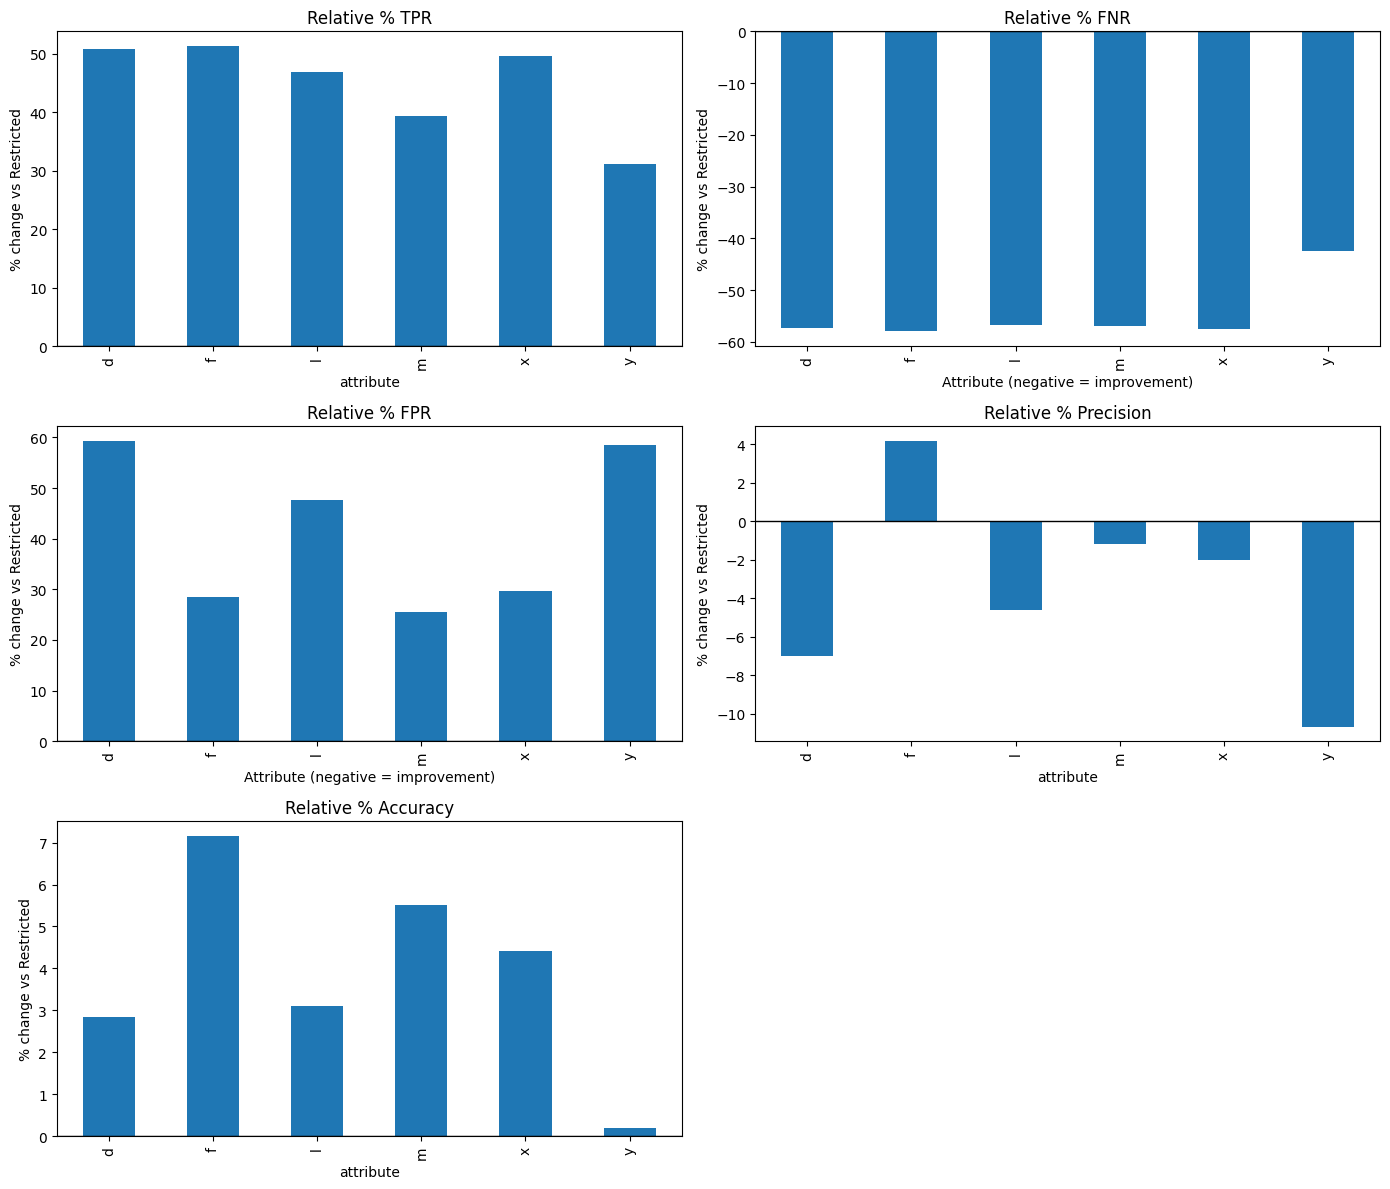


Interpretation:
- Relative % change = (Full - Restricted)/Restricted * 100.
- For TPR/Precision/Accuracy: positive % = improvement; negative = decline.
- For FNR/FPR (error rates): negative % = improvement (error reduced); positive = worse.
- Large positive TPR % combined with modest FPR % may indicate acceptable trade-off; examine per-group balance.
- Values near ± Infinity (if Restricted metric ~0) are set to NaN to avoid misleading spikes.
- Metrics aggregate over all edges a node participates in (both within and between attribute groups). Filter pairs_test for within/between analysis if needed.


In [138]:
# Node-level metrics comparison Full vs Restricted (relative % change plots, 2 per row)
import numpy as np
import pandas as pd
from collections import defaultdict
from math import ceil
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Preconditions: X (full features), Y, feature_names, positives, negatives, attr_map
missing_globals = [g for g in ['X','Y','feature_names','positives','negatives','attr_map'] if g not in globals()]
if missing_globals:
    raise RuntimeError(f"Missing required global variables: {missing_globals}")

# Build consistent pairs list
pairs_all = list(positives) + list(negatives)
if len(pairs_all) != len(X):
    raise RuntimeError("pairs_all length mismatch with X; ensure same construction order.")

# Sensitive attribute per node (attribute label or 'unknown')
node_attr = {int(node): (a if a is not None else 'unknown') for node, a in attr_map.items()}

# Train/test split at edge level (reuse earlier strategy)
X_full = np.asarray(X, dtype=float)
Y_arr = np.asarray(Y, dtype=int)
X_train_full, X_test_full, y_train, y_test, pairs_train, pairs_test = train_test_split(
    X_full, Y_arr, pairs_all, test_size=0.3, random_state=42, stratify=Y_arr
)

# Restricted feature indices (structural only)
restricted_feats = [
    'PA','CN','Jaccard','AdamicAdar','ResAlloc','deg_i','deg_j','CC_mean','CC_diff'
]
name_to_idx = {n:i for i,n in enumerate(feature_names)}
missing = [f for f in restricted_feats if f not in name_to_idx]
if missing:
    raise ValueError(f"Restricted feature(s) not found in feature_names: {missing}")
idx_restricted = [name_to_idx[f] for f in restricted_feats]

X_train_restricted = X_train_full[:, idx_restricted]
X_test_restricted  = X_test_full[:, idx_restricted]

# Fit two logistic models (balanced)
clf_full = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs', random_state=1)
clf_restricted = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs', random_state=1)
clf_full.fit(X_train_full, y_train)
clf_restricted.fit(X_train_restricted, y_train)

proba_full = clf_full.predict_proba(X_test_full)[:,1]
proba_res  = clf_restricted.predict_proba(X_test_restricted)[:,1]
pred_full = (proba_full >= 0.5).astype(int)
pred_res  = (proba_res  >= 0.5).astype(int)

# Duplicate edges for per-node contributions
node_stats_full = defaultdict(lambda: {'TP':0,'FP':0,'TN':0,'FN':0,'edges':0})
node_stats_res  = defaultdict(lambda: {'TP':0,'FP':0,'TN':0,'FN':0,'edges':0})

for (u,v), yt, pf, pr in zip(pairs_test, y_test, pred_full, pred_res):
    for node_stats, p in [(node_stats_full, pf), (node_stats_res, pr)]:
        for node in (u,v):
            ref = node_stats[node]
            ref['edges'] += 1
            if yt == 1 and p == 1:
                ref['TP'] += 1
            elif yt == 0 and p == 1:
                ref['FP'] += 1
            elif yt == 0 and p == 0:
                ref['TN'] += 1
            elif yt == 1 and p == 0:
                ref['FN'] += 1

# Helper to convert dict -> DataFrame with metrics (FNR = FN/(TP+FN))

def build_node_df(stats_dict, label):
    rows = []
    for n, s in stats_dict.items():
        tp, fp, tn, fn, m = s['TP'], s['FP'], s['TN'], s['FN'], s['edges']
        denom_pos = tp + fn
        denom_neg = fp + tn
        tpr = tp / denom_pos if denom_pos else np.nan
        fnr = fn / denom_pos if denom_pos else np.nan  # error rate on positives
        fpr = fp / denom_neg if denom_neg else np.nan
        prec = tp / (tp + fp) if (tp + fp) else np.nan
        acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) else np.nan
        rows.append({
            'node': n,
            'attribute': node_attr.get(int(n), 'unknown'),
            'TP': tp,'FP': fp,'TN': tn,'FN': fn,'edges': m,
            'TPR': tpr,'FNR': fnr,'FPR': fpr,'Precision': prec,'Accuracy': acc,
            'model_set': label
        })
    return pd.DataFrame(rows)

node_df_full = build_node_df(node_stats_full, 'FULL')
node_df_res  = build_node_df(node_stats_res,  'RESTRICTED')
combined = pd.concat([node_df_full, node_df_res], ignore_index=True)

# Unweighted group means (per-node fairness)
metrics_cols = ['TPR','FNR','FPR','Precision','Accuracy']
unweighted = combined.groupby(['model_set','attribute'])[metrics_cols].mean()

# Weighted by edges (traffic impact)
weighted = combined.groupby(['model_set','attribute']).apply(
    lambda g: pd.Series({m: np.average(g[m], weights=g['edges']) for m in metrics_cols})
)

# Pivot for delta calculation (Full - Restricted)
uw_pivot = unweighted.reset_index().pivot(index='attribute', columns='model_set')
wt_pivot = weighted.reset_index().pivot(index='attribute', columns='model_set')

# Helper to compute absolute deltas

def compute_deltas(pivot_df, metrics=('TPR','FNR','FPR','Precision','Accuracy')):
    delta_rows = []
    for attr in pivot_df.index:
        row = {'attribute': attr}
        for m in metrics:
            try:
                full_val = pivot_df.loc[attr, (m,'FULL')]
                res_val  = pivot_df.loc[attr, (m,'RESTRICTED')]
                row[f'{m}_delta'] = full_val - res_val
            except KeyError:
                row[f'{m}_delta'] = np.nan
        delta_rows.append(row)
    return pd.DataFrame(delta_rows).set_index('attribute')

uw_delta = compute_deltas(uw_pivot)
wt_delta = compute_deltas(wt_pivot)

# Relative percent change ((Full - Restricted)/Restricted * 100)
rel_rows = []
for attr in uw_pivot.index:
    rrow = {'attribute': attr}
    for m in metrics_cols:
        try:
            full_val = uw_pivot.loc[attr, (m,'FULL')]
            res_val  = uw_pivot.loc[attr, (m,'RESTRICTED')]
            if pd.isna(res_val) or res_val == 0:
                rrow[f'{m}_rel_pct'] = np.nan
            else:
                rrow[f'{m}_rel_pct'] = (full_val - res_val) / res_val * 100.0
        except KeyError:
            rrow[f'{m}_rel_pct'] = np.nan
    rel_rows.append(rrow)
uw_rel_pct = pd.DataFrame(rel_rows).set_index('attribute')

print("=== Node-Level Unweighted Group Means ===")
print(unweighted)
print("\n=== Node-Level Weighted Group Means ===")
print(weighted)
print("\n=== Unweighted Absolute Deltas (Full - Restricted) ===")
print(uw_delta)
print("\n=== Unweighted Relative % Change (Full vs Restricted) ===")
print(uw_rel_pct)

# Change flags (absolute deltas basis):
flag_rows = []
for attr, r in uw_delta.iterrows():
    flag_rows.append({
        'attribute': attr,
        'TPR_delta': r['TPR_delta'],
        'FNR_delta': r['FNR_delta'],
        'FPR_delta': r['FPR_delta'],
        'Precision_delta': r['Precision_delta'],
        'Accuracy_delta': r['Accuracy_delta'],
        'TPR_drop': r['TPR_delta'] < 0 if not np.isnan(r['TPR_delta']) else np.nan,
        'Precision_drop': r['Precision_delta'] < 0 if not np.isnan(r['Precision_delta']) else np.nan,
        'Accuracy_drop': r['Accuracy_delta'] < 0 if not np.isnan(r['Accuracy_delta']) else np.nan,
        'FPR_worse': r['FPR_delta'] > 0 if not np.isnan(r['FPR_delta']) else np.nan,
        'FNR_worse': r['FNR_delta'] > 0 if not np.isnan(r['FNR_delta']) else np.nan
    })
flag_df = pd.DataFrame(flag_rows).set_index('attribute')
print("\n=== Unweighted Change Flags (absolute deltas) ===")
print(flag_df)

# Plot relative percentage changes (2 plots per row)
try:
    import matplotlib.pyplot as plt
    metrics_to_plot_rel = ['TPR_rel_pct','FNR_rel_pct','FPR_rel_pct','Precision_rel_pct','Accuracy_rel_pct']
    n = len(metrics_to_plot_rel)
    ncols = 2
    nrows = ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(7*ncols, 4*nrows))
    axes = axes.flatten()
    for i, m in enumerate(metrics_to_plot_rel):
        if m not in uw_rel_pct.columns:
            axes[i].set_visible(False)
            continue
        # FIXED quoting issue here by using double quotes for outer f-string
        uw_rel_pct[m].plot(kind='bar', ax=axes[i], title=f"Relative % {m.replace('_rel_pct','')}", color='#1f77b4')
        axes[i].axhline(0, color='black', linewidth=1)
        axes[i].set_ylabel('% change vs Restricted')
        if 'FNR' in m or 'FPR' in m:
            axes[i].set_xlabel('Attribute (negative = improvement)')
    # Hide any extra axes
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Plotting skipped:", e)

print("\nInterpretation:")
print("- Relative % change = (Full - Restricted)/Restricted * 100.")
print("- For TPR/Precision/Accuracy: positive % = improvement; negative = decline.")
print("- For FNR/FPR (error rates): negative % = improvement (error reduced); positive = worse.")
print("- Large positive TPR % combined with modest FPR % may indicate acceptable trade-off; examine per-group balance.")
print("- Values near ± Infinity (if Restricted metric ~0) are set to NaN to avoid misleading spikes.")
print("- Metrics aggregate over all edges a node participates in (both within and between attribute groups). Filter pairs_test for within/between analysis if needed.")